<h1>GMM using EM algorithm</h1>

Gaussian mixture model is used to find the sampling distribution for data set. We will first use the library to have a feel of how the GMM works and then code it ourself for a better understanding.

Code has been adopted from <a href='https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html'>here</a>.

<h2>Example use</h2> <br>


<ui>
    <li>Better than K means as K means assumes spherical distribution along different dimensions (with hard boundaries)</li>
    <li>Used to sample data from a distribution (non-standardized distribution)</li>
</ui>

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplt
import random

<h2>Comparison with K Means</h2>

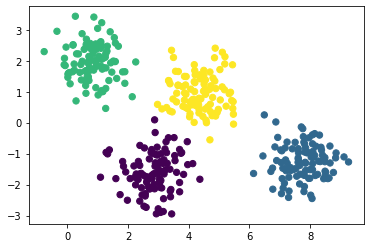

In [10]:
# generating the data and visualizing it

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting


# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
mplt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

<h3>K means</h3>

In [20]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    print("labels: ",labels[0:5])                                    # prints the labels (hard labels for first 5 points)
    
    # plot the input data
    ax = ax or mplt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(mplt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

labels:  [1 0 0 3 0]


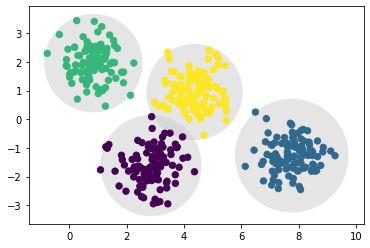

In [21]:
# plots the kmeans distribution (based on radii calculated from cdist function)
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

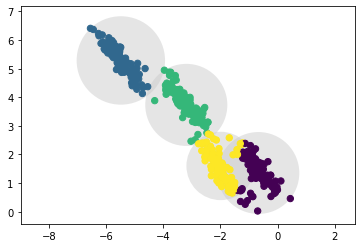

In [17]:
# irrespective of the data input give, the shapes remain speherical in the kmeans
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

<h3>GMM</h3>

In [33]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X)
labels = gmm.predict(X)

In [34]:
# printing the labels of first 5 to show how it is not hard coded
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


In [39]:
# function to visualize clustering from GMM
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or mplt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or mplt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

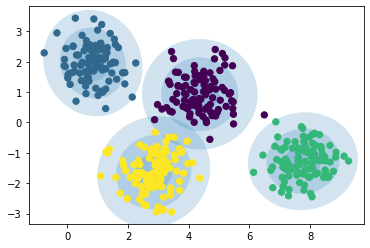

In [41]:
plot_gmm(gmm, X)

In [42]:
# the probability of weights of mixing of each of the 4 components
gmm.weights_

array([0.25454734, 0.24963804, 0.24878736, 0.24702726])

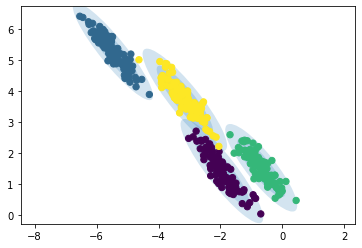

In [44]:
# GMM adjusts to the stretched shape of the data distribution
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X_stretched)
plot_gmm(gmm, X_stretched)

<h2>Drawing random samples from a distribution</h2>

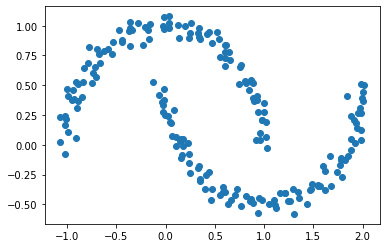

In [45]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
mplt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

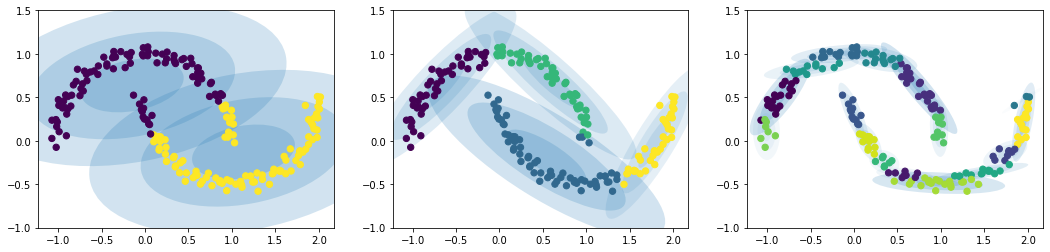

In [55]:
# we can find a mixture with different number of distribution into the gaussian mixtures
fig = mplt.figure(figsize=(18,4))

mplt.subplot(1,3,1)
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

mplt.subplot(1,3,2)
gmm4 = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm4, Xmoon)

mplt.subplot(1,3,3)
gmm16 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)

<h3>Sampling from mixture model</h3><br>
The GMM model provides a mixture model which uses EM algorithm to best fit the data (to create a new distribution). The model provides weights to each distribution. The data is drawn using the following method:
<ol>
    <li>pick a distribution from the mixture with probability equal to weight for that distribution</li>
    <li>sample from that distribution</li>
</ol>

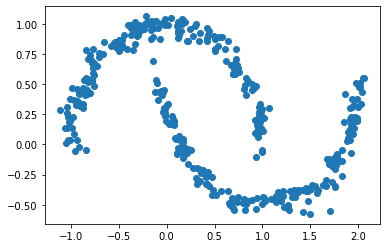

In [70]:
# using the best mixture model (using distribution = 16), we can draw samples from this distribution
Xnew = gmm16.sample(400)[0]
mplt.scatter(Xnew[:,0], Xnew[:,1]);

# drawing the samples look very similar to the distribution we wanted to generate the data from

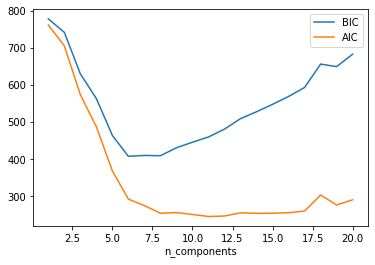

In [72]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

mplt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
mplt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
mplt.legend(loc='best')
mplt.xlabel('n_components');

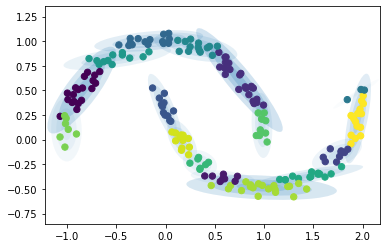

In [73]:
# based on BIC and AIC, we can restrict ourselves to 8 clusters
gmm8 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm8, Xmoon)

<h2>EM Algorithm</h2>

In a latent model (lets consider the mixture model where where we have a latent oracle which tells which distribution should we draw the sample from), the probability of drawing a variable is given by:<br>
$P(X_i=x) = \sum_{k=1}^K\pi_k(P(X_i=x\vert Z_i=k)$ <br>
where:<br>
$\pi_k$ is the probability that it is drawn from the distribution $k$ : or weights from the model<br>
$Z_i=k$ is the condition that distribution $k$ is selected by the oracle.



In the first step, we find a posterior to $Z_i$ based on the current parameters. In the second step, we maximize the likelihood function to find the optimal parameters under the known posterior. Thus this is a vicious cycle but it is also small steps to solve the problem.

Expectation maximization algorithm (as its name suggests), uses two steps:
<ol>
    <li>Expectation step  : using an initial means, variances, we can find the posterior as which x belongs to which cluster</li>
    <li>Maximization step : based on the previous step, we can redefine means and covariances</li>
</ol>


Codes have been adopted from <a href="http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/">here</a>.

<h3>EM Algorithm</h3>

In [172]:
from scipy.stats import multivariate_normal

In [218]:
# give equal weights to all the 8 dimensions
k = 8
n = Xmoon.shape[0]
weights = np.ones((k))/k

# randomly assign each of the data points in xmoon to one of the 8
assign = np.random.randint(k,size=(200))

# finding means and variance from random assignment
means  = [np.mean(Xmoon[assign==j],axis=0) for j in range(k)]
covar  = [np.cov(Xmoon[assign==j].T) for j in range(k)]

for iter in range(3000):
    # ---------- expectation step ------------------
    # finding the posterior of the probability Z_i = k using pdf of the distribution (expectation)
    # expectation : we estimate the probability that a given data point belongs to a certain distribution
    weights_ij   = np.zeros((n,k))
    weights_sum  = np.zeros((n,k))
    
    for j in range(k):
        weights_ij[:,j] =  multivariate_normal.pdf(Xmoon,means[j],covar[j])
        
    weights_ij = np.multiply(weights_ij,weights)
    weights_ij = np.divide(weights_ij,np.sum(weights_ij,axis=1).reshape(n,1))
    weights    = np.mean(weights_ij,axis=0)
    
    # --------- maximization step ------------------
    # based on weights and the covariances and the new Z_i, find new means and covariance by optimization of likelihood  
    # maximization: we use optimization to derive the best value of means and covariance
    for j in range(k):
        weight = weights_ij[:, [j]]
        total_weight = weight.sum()
        means[j] = (Xmoon* weight).sum(axis=0) / total_weight
        covar[j] = np.cov(Xmoon.T, aweights=(weight/total_weight).flatten(), bias=True)

<h3>Sampling after EM algorithm</h3>

We will use different measures to check the EM algorithm performance. First is we can plot and see if the distribution is similar to the original distribution of Xmoon. We use monte carlo simulation from the mixture model by first selecting the distribution to draw from and secondly, using means and variance from the distribution to draw from.

Text(0.5, 1.0, 'Xmoon samples from EM algorithm')

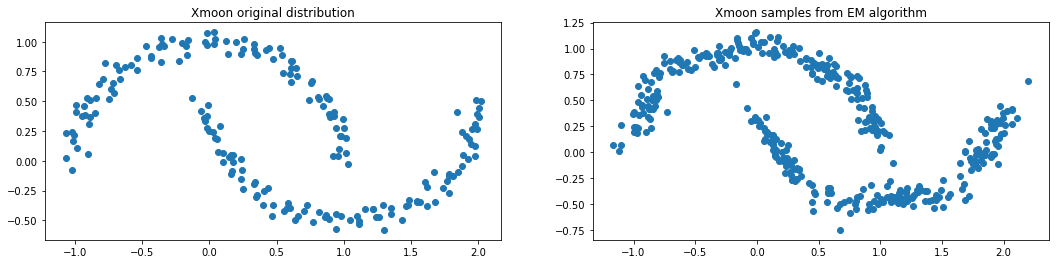

In [219]:
# we can simulate 400 draws to check
samples = []
for iter in range(400):
    Z = np.random.choice(k, 1, p=weights)[0]   # the distribution from which the numbers have to be sampled
    x = np.random.multivariate_normal(means[Z], covar[Z], 1)[0]
    samples.append(x)
    
samples = np.array(samples)

fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.scatter(Xmoon[:, 0], Xmoon[:, 1]);
mplt.title('Xmoon original distribution')

mplt.subplot(1,2,2)
mplt.scatter(samples[:, 0], samples[:, 1]);
mplt.title('Xmoon samples from EM algorithm')